In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.metrics import auc

# 1.

In [2]:
# dataset_wine = load_wine()
# wine_df = pd.DataFrame(dataset_wine.data, columns=dataset_wine.feature_names)
# wine_df['class'] = dataset_wine.target
# wine_df.head()

In [11]:
dataset_wine = pd.read_csv('winequality-white.csv', sep=';')
wine_df = dataset_wine
wine_df = wine_df[wine_df['quality'] != 3]
wine_df = wine_df[wine_df['quality'] != 9]
print(wine_df['quality'].unique(), len(wine_df), len(dataset_wine))
wine_df.head()

[6 5 7 8 4] 4873 4898


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [5]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']
# X = wine_df.drop('class', axis=1)
# y = wine_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="GPU")
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
# model = SVC(kernel='linear', probability=True, random_state=42)
# model.fit(X_train, y_train)

Learning rate set to 0.190875
0:	learn: 1.4381623	test: 1.4433516	best: 1.4433516 (0)	total: 16.4ms	remaining: 5.71s
1:	learn: 1.3313461	test: 1.3480157	best: 1.3480157 (1)	total: 31.3ms	remaining: 5.44s
2:	learn: 1.2526574	test: 1.2777523	best: 1.2777523 (2)	total: 44.9ms	remaining: 5.2s
3:	learn: 1.1934003	test: 1.2223253	best: 1.2223253 (3)	total: 58.1ms	remaining: 5.03s
4:	learn: 1.1470303	test: 1.1801911	best: 1.1801911 (4)	total: 72.4ms	remaining: 4.99s
5:	learn: 1.1114113	test: 1.1489386	best: 1.1489386 (5)	total: 89.1ms	remaining: 5.11s
6:	learn: 1.0845541	test: 1.1248683	best: 1.1248683 (6)	total: 104ms	remaining: 5.08s
7:	learn: 1.0623509	test: 1.1090710	best: 1.1090710 (7)	total: 117ms	remaining: 5s
8:	learn: 1.0416273	test: 1.0909186	best: 1.0909186 (8)	total: 131ms	remaining: 4.95s
9:	learn: 1.0273194	test: 1.0808055	best: 1.0808055 (9)	total: 145ms	remaining: 4.94s
10:	learn: 1.0124277	test: 1.0695150	best: 1.0695150 (10)	total: 159ms	remaining: 4.9s
11:	learn: 0.9964829	

# 2.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

In [7]:
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test, y_predict)

# Accuracy
accuracy = accuracy_score(y_test, y_predict)

#Precision
precision = precision_score(y_test, y_predict, average='weighted')

#Recall
recall = recall_score(y_test, y_predict, average='weighted')

#Specificity
specificity_per_class = []

for i in range(len(cm)):
    true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_positives = np.sum(np.delete(cm[:, i], i))
    specificity = true_negatives / (true_negatives + false_positives)
    specificity_per_class.append(specificity)

print(f'Specificity per class: {specificity_per_class}\nAverage Specificity: {np.mean(specificity_per_class):.3f}\n')
print(f'Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}\n')
print(f'Conf matrix:\n{cm}')

Specificity per class: [0.9936305732484076, 0.8830409356725146, 0.5850467289719626, 0.9336670838548186, 0.9914893617021276]
Average Specificity: 0.877

Accuracy: 0.622, Precision: 0.625, Recall: 0.622

Conf matrix:
[[  9  15   9   0   0]
 [  4 170 112   5   0]
 [  1  61 335  41   2]
 [  1   3  88  78   6]
 [  0   1  13   7  14]]


# 3, 4. 

## ROC-AUG on test

In [8]:
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])
# y_bin = label_binarize(y_test, classes=[0, 1, 2])
y_bin

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

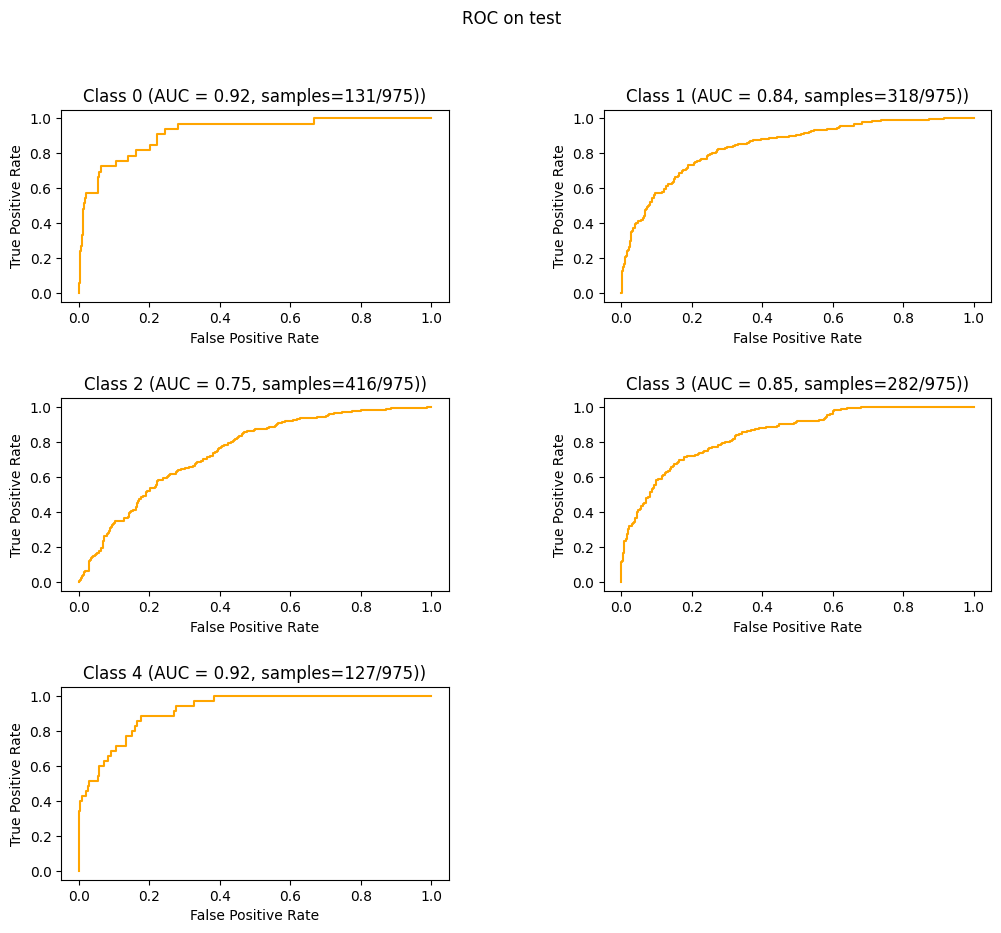

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_predict_probs[:, i])
    roc_auc[i] = roc_auc_score(y_bin[:, i], y_predict_probs[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on test')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr[i], tpr[i], 'orange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc[i]:.2f}, samples={len(tpr[i])}/{len(X_test)}))')

## ROC-AUG on train

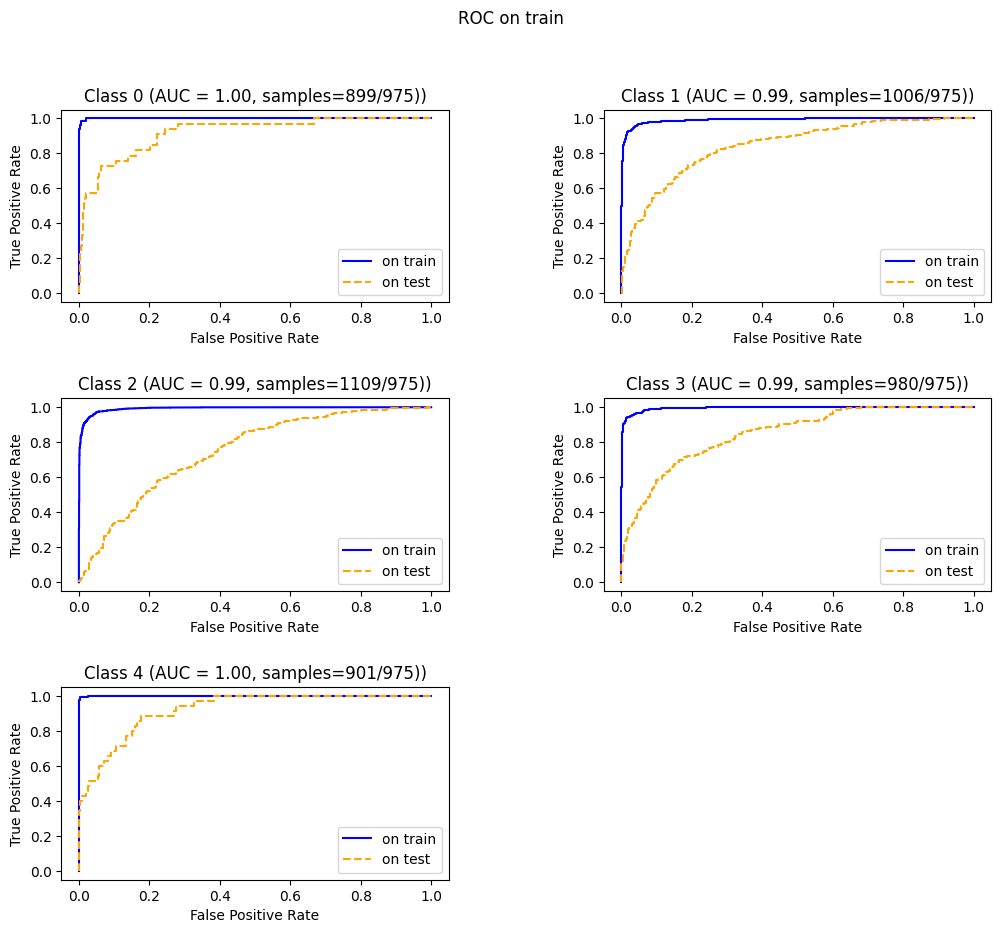

In [12]:
y_bin_train = label_binarize(y_train, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_train, classes=[0, 1, 2])

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
y_predict_probs_train = model.predict_proba(X_train)

for i in range(y_bin_train.shape[1]):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_bin_train[:, i], y_predict_probs_train[:, i])
    roc_auc_train[i] = roc_auc_score(y_bin_train[:, i], y_predict_probs_train[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on train')
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin_train.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin_train.shape[1] // 2 + 1, y_bin_train.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_train[i], tpr_train[i], linestyle='-', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_train[i]:.2f}, samples={len(tpr_train[i])}/{len(X_test)}))')
    plt.legend()

## ROC-AUG on cross-val

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

Learning rate set to 0.205403
0:	learn: 1.4272494	total: 20.2ms	remaining: 7.06s
1:	learn: 1.3168700	total: 33.2ms	remaining: 5.79s
2:	learn: 1.2396202	total: 47.5ms	remaining: 5.5s
3:	learn: 1.1771774	total: 60.6ms	remaining: 5.24s
4:	learn: 1.1322280	total: 73.7ms	remaining: 5.08s
5:	learn: 1.0965193	total: 85.8ms	remaining: 4.92s
6:	learn: 1.0663994	total: 98.6ms	remaining: 4.83s
7:	learn: 1.0439287	total: 111ms	remaining: 4.75s
8:	learn: 1.0253385	total: 124ms	remaining: 4.7s
9:	learn: 1.0098726	total: 137ms	remaining: 4.65s
10:	learn: 0.9948474	total: 150ms	remaining: 4.62s
11:	learn: 0.9835186	total: 163ms	remaining: 4.59s
12:	learn: 0.9747274	total: 176ms	remaining: 4.57s
13:	learn: 0.9635019	total: 189ms	remaining: 4.54s
14:	learn: 0.9511045	total: 202ms	remaining: 4.51s
15:	learn: 0.9430674	total: 216ms	remaining: 4.51s
16:	learn: 0.9346183	total: 230ms	remaining: 4.51s
17:	learn: 0.9274339	total: 243ms	remaining: 4.48s
18:	learn: 0.9203146	total: 255ms	remaining: 4.45s
19:	le

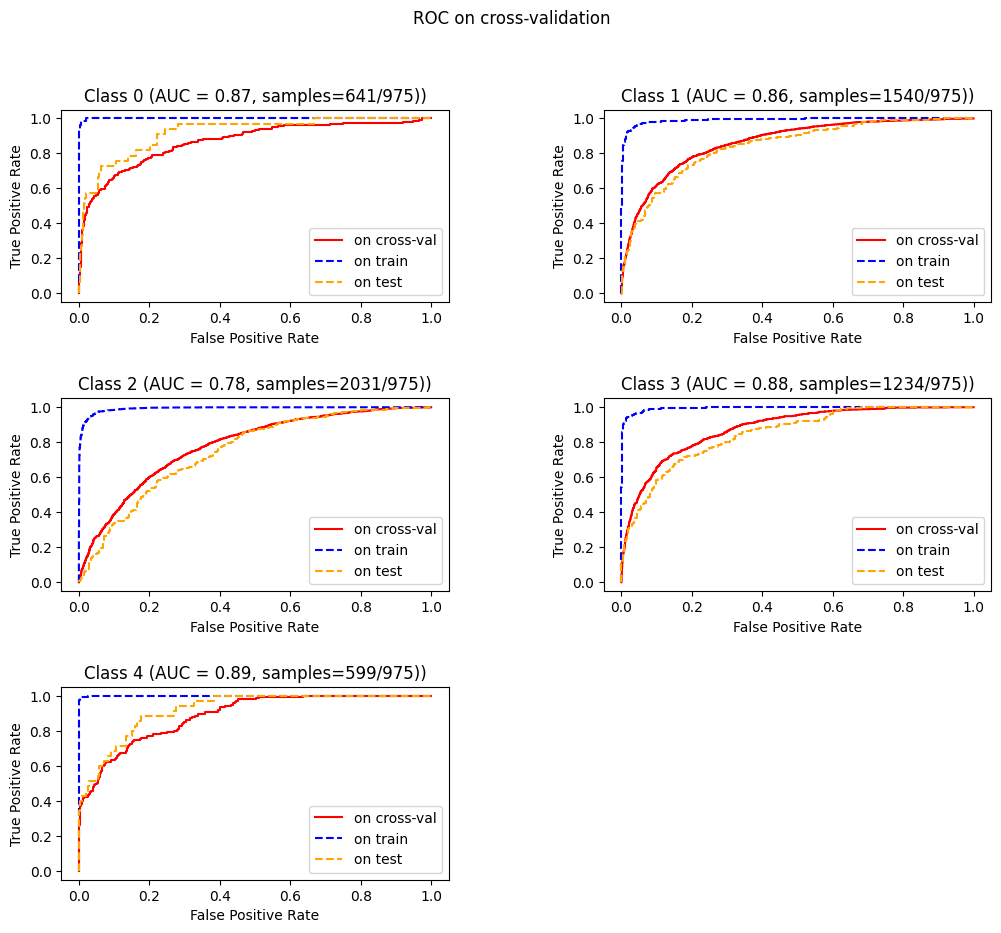

In [16]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

y_bin_cross_val = label_binarize(y, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

model_cross_val = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="GPU")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_predict_probs_cross_val = cross_val_predict(model_cross_val, X, y, cv=cv, method='predict_proba')

fpr_cross_val = dict()
tpr_cross_val = dict()
roc_auc_cross_val = dict()

for i in range(y_bin.shape[1]):
    fpr_cross_val[i], tpr_cross_val[i], _ = roc_curve(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])
    roc_auc_cross_val[i] = roc_auc_score(y_bin_cross_val[:, i], y_predict_probs_cross_val[:, i])

plt.figure(figsize=(12, 10))
plt.suptitle('ROC on cross-validation')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(y_bin_cross_val.shape[1]):
    plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
    plt.plot(fpr_cross_val[i], tpr_cross_val[i], linestyle='-', color='red', label='on cross-val')
    plt.plot(fpr_train[i], tpr_train[i], linestyle='--', color='blue', label='on train')
    plt.plot(fpr[i], tpr[i], linestyle='--', color='orange', label='on test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} (AUC = {roc_auc_cross_val[i]:.2f}, samples={len(tpr_cross_val[i])}/{len(X_test)}))')
    plt.legend()


## ROC confidence interval

In [17]:
print(len(y_predict_probs_cross_val))
print(len(y))

4873
4873


In [18]:
from scipy.stats import norm

quality
6    2198
5    1457
7     880
8     175
4     163
Name: count, dtype: int64
Learning rate set to 0.205403
0:	learn: 1.4272492	total: 18.7ms	remaining: 6.54s
1:	learn: 1.3168701	total: 32.4ms	remaining: 5.64s
2:	learn: 1.2396202	total: 51.8ms	remaining: 6s
3:	learn: 1.1771774	total: 66.5ms	remaining: 5.75s
4:	learn: 1.1322280	total: 79.5ms	remaining: 5.48s
5:	learn: 1.0965193	total: 93ms	remaining: 5.33s
6:	learn: 1.0663994	total: 106ms	remaining: 5.2s
7:	learn: 1.0439288	total: 119ms	remaining: 5.08s
8:	learn: 1.0253385	total: 131ms	remaining: 4.98s
9:	learn: 1.0098726	total: 145ms	remaining: 4.92s
10:	learn: 0.9948474	total: 158ms	remaining: 4.88s
11:	learn: 0.9835186	total: 172ms	remaining: 4.84s
12:	learn: 0.9747274	total: 185ms	remaining: 4.8s
13:	learn: 0.9635020	total: 198ms	remaining: 4.75s
14:	learn: 0.9511044	total: 211ms	remaining: 4.71s
15:	learn: 0.9430675	total: 225ms	remaining: 4.69s
16:	learn: 0.9346184	total: 238ms	remaining: 4.67s
17:	learn: 0.9274339	total: 25

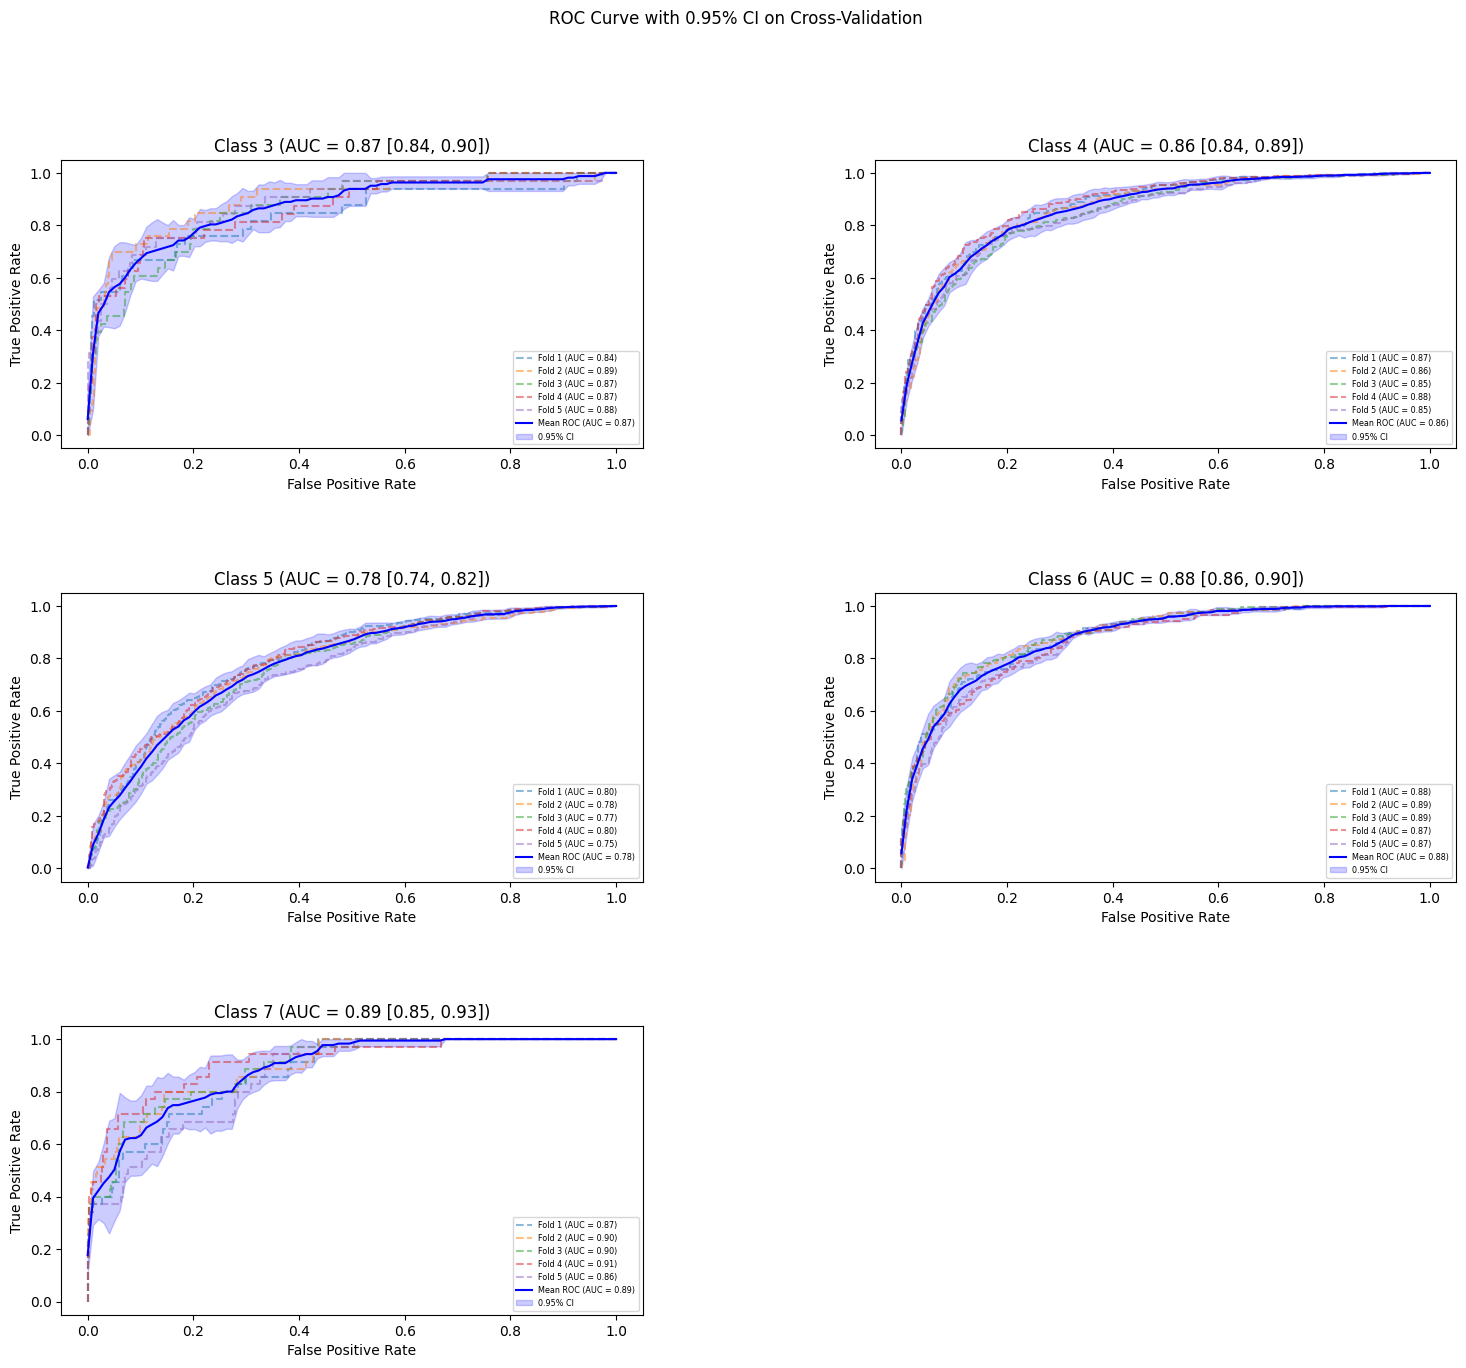

In [21]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']
print(y.value_counts())
y_bin_cross_val = label_binarize(y, classes=[4, 5, 6, 7, 8])
# y_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

model_cross_val = CatBoostClassifier(loss_function='MultiClass', iterations=350, random_seed=42, task_type="GPU")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = {i: [] for i in range(y_bin_cross_val.shape[1])} # Словарь TPR
aucs = {i: [] for i in range(y_bin_cross_val.shape[1])} # Словарь AUC
mean_fpr = np.linspace(0, 1, 100)

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2) # Для доверительного

plt.figure(figsize=(18, 15))
plt.suptitle(f'ROC Curve with {confidence_level}% CI on Cross-Validation')
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for fold_idx, (train, test) in enumerate(cv.split(X, y)): # цикл по фолдам
    model_cross_val.fit(X.iloc[train], y.iloc[train])
    y_predict_probs = model_cross_val.predict_proba(X.iloc[test])
    
    for i in range(y_bin_cross_val.shape[1]): # Цикл по классам
        fpr, tpr, _ = roc_curve(y_bin_cross_val[test, i], y_predict_probs[:, i])
        roc_auc = auc(fpr, tpr)
        aucs[i].append(roc_auc)
        
        tpr_interp = np.interp(mean_fpr, fpr, tpr) # Интерполяция, для получения промежуточных точек, кол-во точек = mean_fpr
        tprs[i].append(tpr_interp)
        
        plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
        plt.plot(fpr, tpr, linestyle='--', label=f'Fold {fold_idx+1} (AUC = {roc_auc:.2f})', alpha=0.5)

for i in range(y_bin_cross_val.shape[1]): # Цикл по классам
    mean_tpr = np.mean(tprs[i], axis=0)
    mean_auc = np.mean(aucs[i]) # Средние
    std_auc = np.std(aucs[i]) # Стандартное отклонение

    confidence_lower = max(0, mean_auc - z_score * std_auc) # Высчитываем доверительный интервал
    confidence_upper = min(1, mean_auc + z_score * std_auc) #

    tpr_std = np.std(tprs[i], axis=0)

    plt.subplot(y_bin_cross_val.shape[1] // 2 + 1, y_bin_cross_val.shape[1] % 2 + 1, i + 1)
    plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.fill_between(mean_fpr, np.maximum(0, mean_tpr - z_score * tpr_std), np.minimum(1, mean_tpr + z_score * tpr_std), color='b', alpha=0.2, label=f'{confidence_level}% CI')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i+3} (AUC = {mean_auc:.2f} [{confidence_lower:.2f}, {confidence_upper:.2f}])')
    plt.legend(loc="lower right", fontsize='xx-small')

print(y.value_counts())
plt.show()

## Precision-Recall curve

In [14]:
from sklearn.metrics import precision_recall_curve

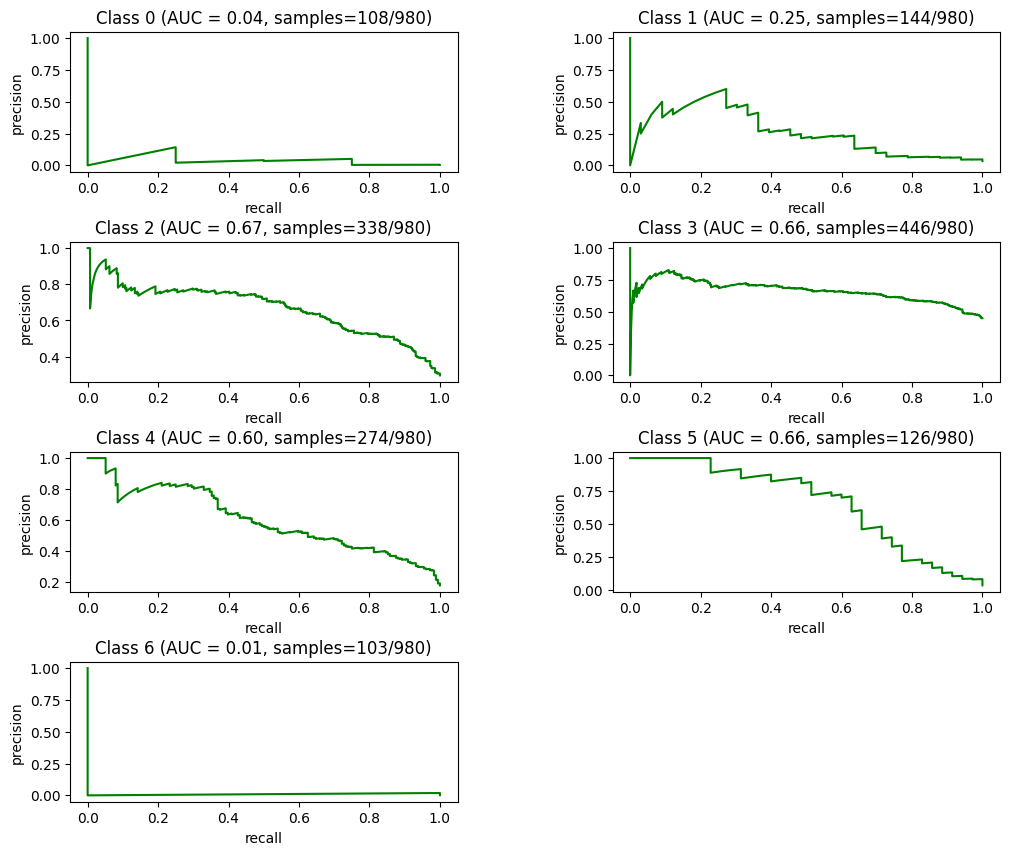

In [15]:
fpr2 = dict()
tpr2 = dict()
pr_auc = dict()
y_predict_probs = model.predict_proba(X_test)

for i in range(y_bin.shape[1]):
    fpr2[i], tpr2[i], _ = precision_recall_curve(y_bin[:, i], y_predict_probs[:, i])
    pr_auc[i] = auc(tpr2[i], fpr2[i])

plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(y_bin.shape[1]):
    #print(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.subplot(y_bin.shape[1] // 2 + 1, y_bin.shape[1] % 2 + 1, i + 1)
    plt.plot(tpr2[i], fpr2[i], 'green')
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.title(f'Class {i} (AUC = {pr_auc[i]:.2f}, samples={len(tpr[i])}/{len(X_test)})')

# 5.

In [16]:
from sklearn.metrics import log_loss
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [17]:
X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

# 2. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_bin5 = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8, 9])

# 3. Обучение моделей
# AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

c:\Users\ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GradientBoostingClassifier(random_state=42)

c:\Users\ivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



class 0
AdaBoost - AUC: 0.54, Log Loss: 0.16, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.53, Log Loss: 0.09, Precision: 0.00, Recall: 0.00

class 1
AdaBoost - AUC: 0.51, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.80, Log Loss: 0.12, Precision: 0.46, Recall: 0.36

class 2
AdaBoost - AUC: 0.67, Log Loss: 0.66, Precision: 0.41, Recall: 0.88
Gradient Boosting - AUC: 0.80, Log Loss: 0.50, Precision: 0.63, Recall: 0.53

class 3
AdaBoost - AUC: 0.48, Log Loss: 0.90, Precision: 0.47, Recall: 0.38
Gradient Boosting - AUC: 0.68, Log Loss: 0.70, Precision: 0.57, Recall: 0.75

class 4
AdaBoost - AUC: 0.70, Log Loss: 0.47, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.83, Log Loss: 0.36, Precision: 0.56, Recall: 0.34

class 5
AdaBoost - AUC: 0.69, Log Loss: 0.24, Precision: 0.00, Recall: 0.00
Gradient Boosting - AUC: 0.91, Log Loss: 0.10, Precision: 0.69, Recall: 0.26

class 6
AdaBoost - AUC: 0.93, Log Loss: 0.02, Precision: 0.00, Recall: 0.00

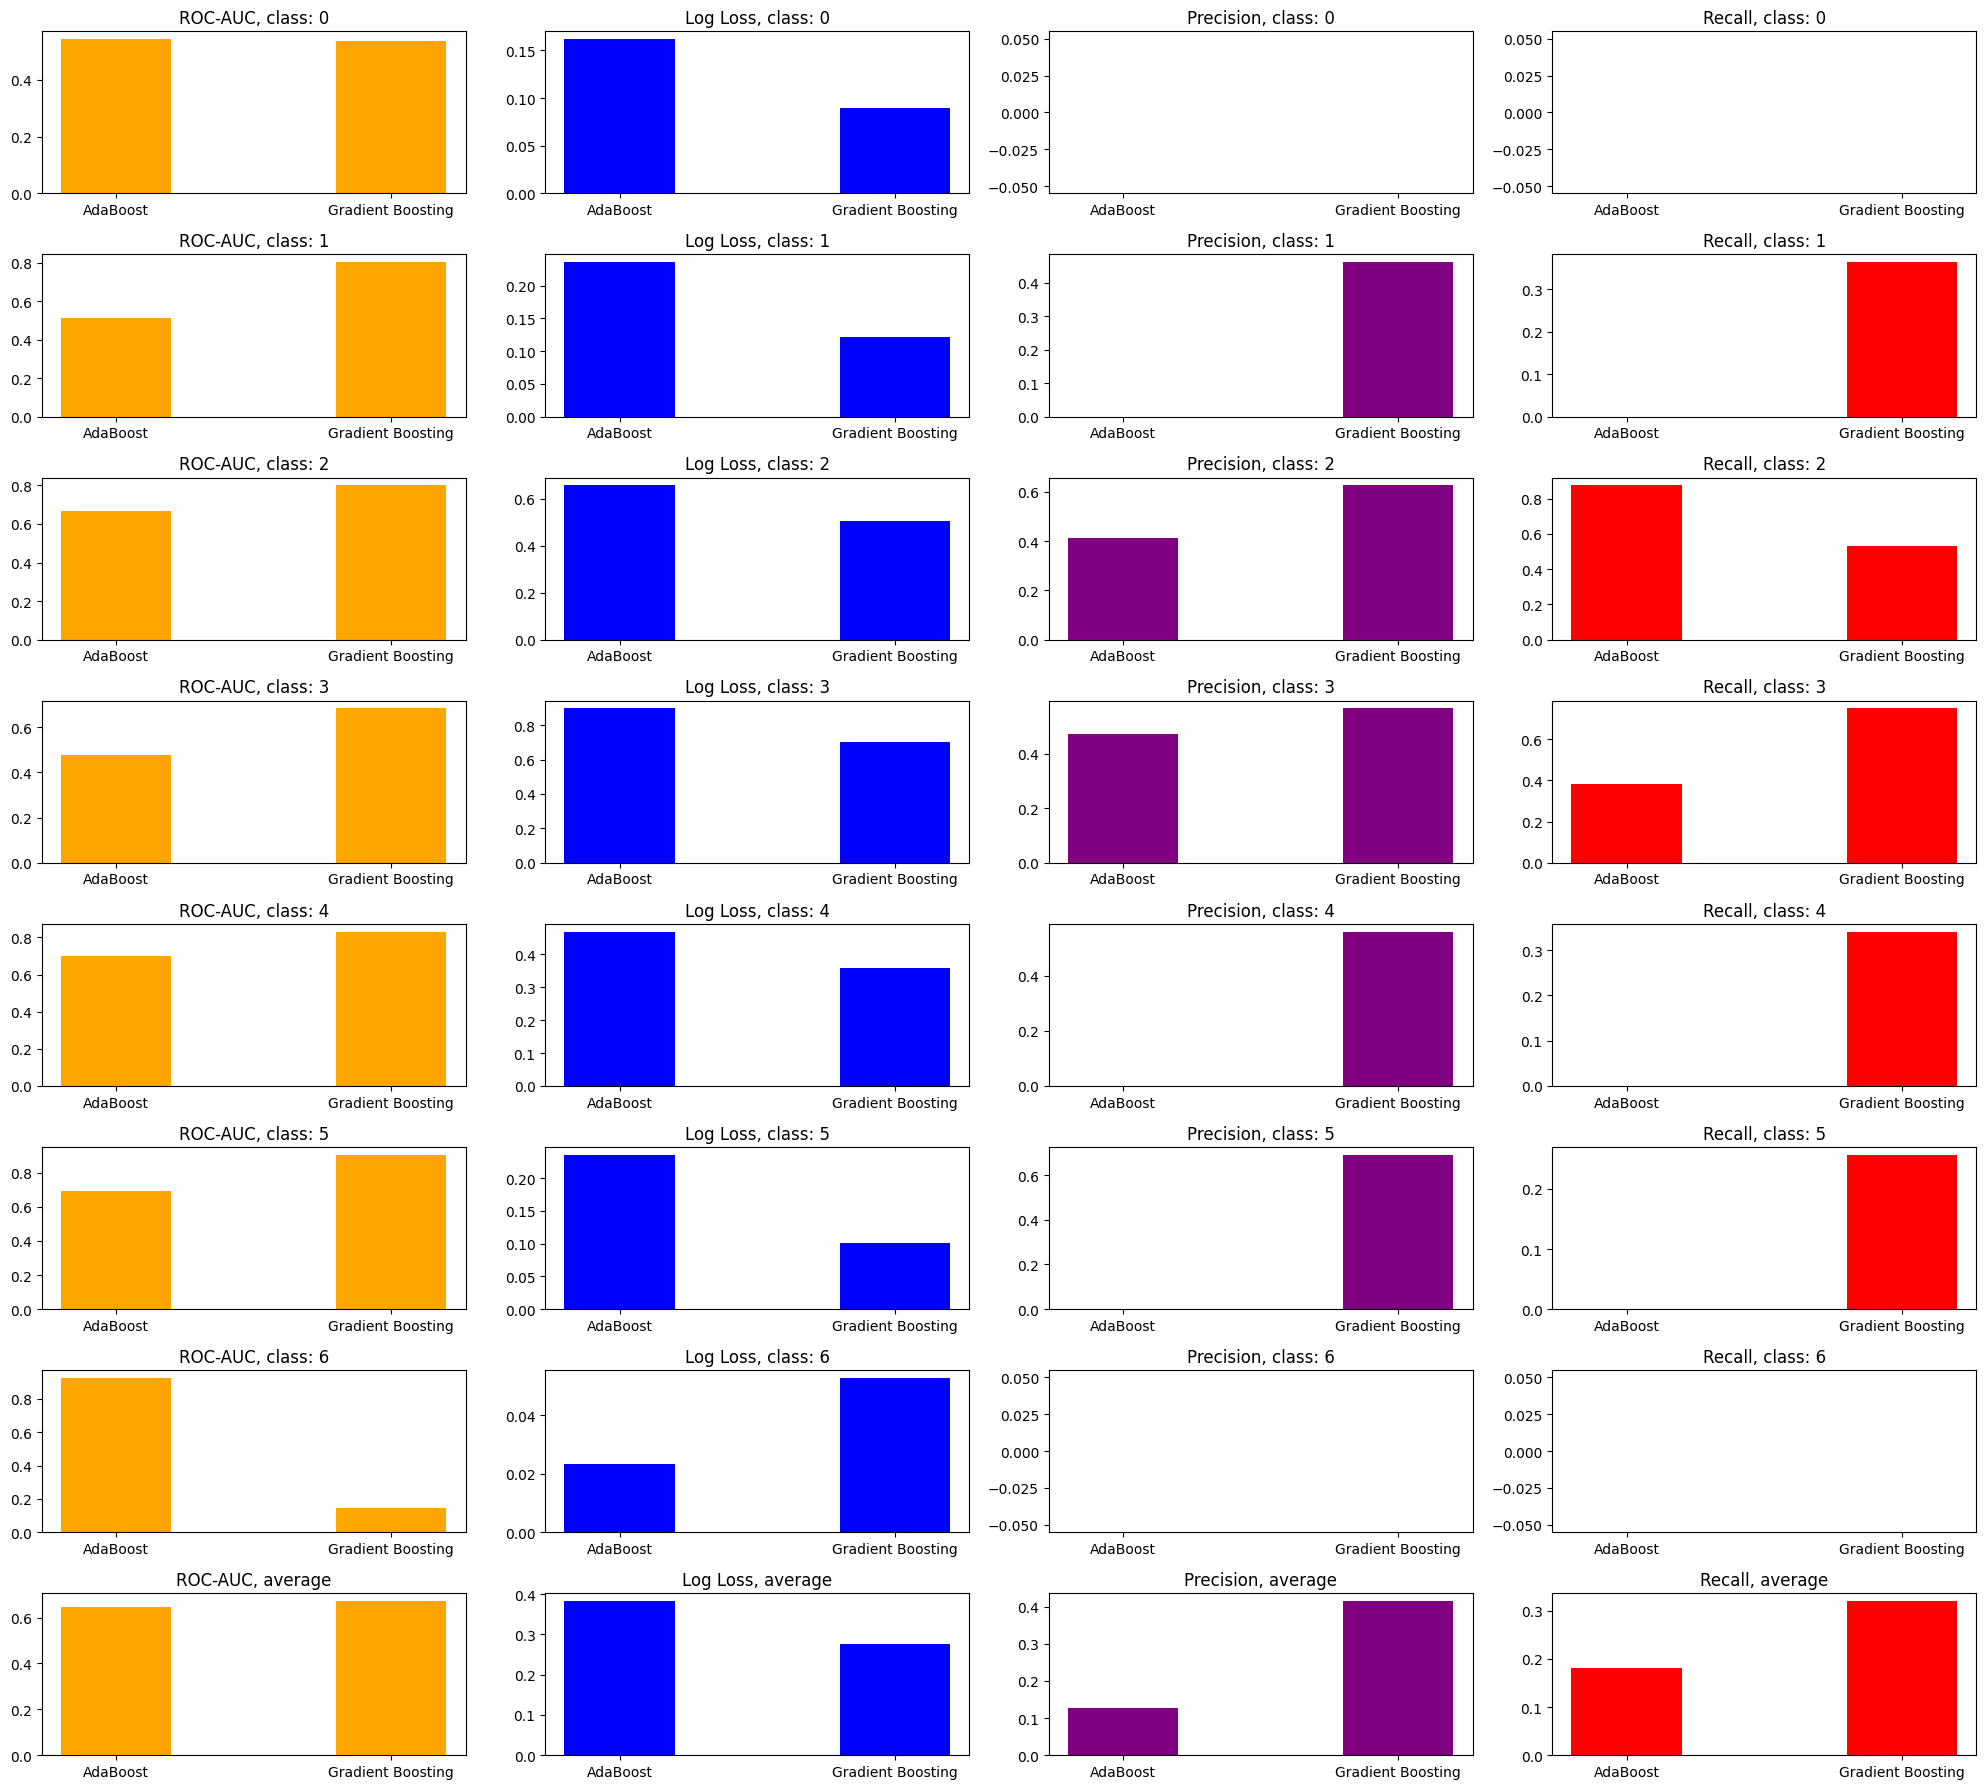

In [18]:
y_pred_ada = ada_model.predict(X_test)
y_pred_proba_ada = ada_model.predict_proba(X_test)

y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

precision_ada = precision_score(y_test, y_pred_ada, average=None)
precision_gb = precision_score(y_test, y_pred_gb, average=None)

recall_ada = recall_score(y_test, y_pred_ada, average=None)
recall_gb = recall_score(y_test, y_pred_gb, average=None)

avg_auc_ada, avg_auc_gb = 0, 0
avg_log_loss_ada, avg_log_loss_gb = 0, 0
avg_precision_ada, avg_precision_gb = 0, 0
avg_recall_ada, avg_recall_gb = 0, 0

num_of_metrics = 4
fig, ax = plt.subplots(y_bin.shape[1] + 1, num_of_metrics, figsize=(20, 18))
for i in range(y_bin.shape[1]):
    roc_auc_ada = roc_auc_score(y_bin5[:, i], y_pred_proba_ada[:, i]) 
    roc_auc_gb = roc_auc_score(y_bin5[:, i], y_pred_proba_gb[:, i])

    log_loss_ada = log_loss(y_bin5[:,i], y_pred_proba_ada[:,i])
    log_loss_gb = log_loss(y_bin5[:,i], y_pred_proba_gb[:,i])
    #log_loss_ada = log_loss(y_test, y_pred_proba_ada)
    #log_loss_gb = log_loss(y_test, y_pred_proba_gb)

    avg_auc_ada += roc_auc_ada
    avg_auc_gb += roc_auc_gb
    avg_log_loss_ada += log_loss_ada
    avg_log_loss_gb += log_loss_gb
    avg_precision_ada += precision_ada[i]
    avg_precision_gb += precision_gb[i]
    avg_recall_ada += recall_ada[i]
    avg_recall_gb += recall_gb[i]

    print(f"\nclass {i}")
    #print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
    #print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
    print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}, Precision: {precision_ada[i]:.2f}, Recall: {recall_ada[i]:.2f}")
    print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}, Precision: {precision_gb[i]:.2f}, Recall: {recall_gb[i]:.2f}")

    # Визуализация результатов
    labels = ['AdaBoost', 'Gradient Boosting']
    auc_scores = [roc_auc_ada, roc_auc_gb]
    log_losses = [log_loss_ada, log_loss_gb]
    #accuracies = [accuracy_ada, accuracy_gb]
    precisions = [precision_ada[i], precision_gb[i]]
    recalls = [recall_ada[i], recall_gb[i]]

    x = np.arange(len(labels))

    titles = [f'ROC-AUC, class: {i}', f'Log Loss, class: {i}', f'Precision, class: {i}', f'Recall, class: {i}']
    ax[i][0].bar(x, auc_scores, 0.4, label=f'AUC, class: {i}', color='orange')
    ax[i][1].bar(x, log_losses, 0.4, label=f'Log Loss, class: {i}', color='blue')
    ax[i][2].bar(x, precisions, 0.4, label=f'Precision, class: {i}', color='purple')
    ax[i][3].bar(x, recalls, 0.4, label=f'Recall, class: {i}', color='red')

    for (j, a) in enumerate(ax[i]):
        a.set_title(titles[j])
        a.set_xticks(x)
        a.set_xticklabels(labels)
        #a.legend()

avg_auc_ada /= y_bin.shape[1]
avg_auc_gb /= y_bin.shape[1]
avg_log_loss_ada /= y_bin.shape[1]
avg_log_loss_gb /= y_bin.shape[1]
avg_precision_ada /= y_bin.shape[1]
avg_precision_gb /= y_bin.shape[1]
avg_recall_ada /= y_bin.shape[1]
avg_recall_gb /= y_bin.shape[1]

print(f"\nAverage")
#print(f"AdaBoost - AUC: {roc_auc_ada:.2f}, Log Loss: {log_loss_ada:.2f}")
#print(f"Gradient Boosting - AUC: {roc_auc_gb:.2f}, Log Loss: {log_loss_gb:.2f}")
print(f"AdaBoost - AUC: {avg_auc_ada:.2f}, Log Loss: {avg_log_loss_ada:.2f}, Precision: {avg_precision_ada:.2f}, Recall: {avg_recall_ada:.2f}")
print(f"Gradient Boosting - AUC: {avg_auc_gb:.2f}, Log Loss: {avg_log_loss_gb:.2f}, Precision: {avg_precision_gb:.2f}, Recall: {avg_recall_gb:.2f}")

titles = [f'ROC-AUC, average', f'Log Loss, average', f'Precision, average', f'Recall, average']
ax[y_bin.shape[1]][0].bar(x, [avg_auc_ada, avg_auc_gb], 0.4, label=f'AUC, average', color='orange')
ax[y_bin.shape[1]][1].bar(x, [avg_log_loss_ada, avg_log_loss_gb], 0.4, label=f'Log Loss, average', color='blue')
ax[y_bin.shape[1]][2].bar(x, [avg_precision_ada, avg_precision_gb], 0.4, label=f'Precision, average', color='purple')
ax[y_bin.shape[1]][3].bar(x, [avg_recall_ada, avg_recall_gb], 0.4, label=f'Recall, average', color='red')
for (j, a) in enumerate(ax[y_bin.shape[1]]):
    a.set_title(titles[j])
    a.set_xticks(x)
    a.set_xticklabels(labels)

plt.tight_layout()
plt.show()